In [45]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import wittgenstein as lw

In [46]:
df = pd.read_csv("/home/damessina/Desktop/df_pulito.csv")

In [47]:
df.drop(columns=['album_title', 'track_title', 'track_genres', 'track_genres_all', 'track_id', 'artist_id'], inplace=True)

In [48]:
df_split1 = df[df['split']=='training']
df_split2 = df[df['split']=='validation']
con = [df_split1, df_split2]
df_train = pd.concat(con, ignore_index=True)
df_train.drop(columns=['split'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [49]:
attributes = [col for col in df_train.columns if col != 'artist_wikipedia_page']
X_train = df_train[attributes].values
y_train = df_train['artist_wikipedia_page']

In [50]:
df_test = df[df['split']=='test']
df_test.drop(columns=['split'], inplace=True)
df_test.reset_index(drop=True, inplace=True)

/home/damessina/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [51]:
attributes = [col for col in df_test.columns if col != 'artist_wikipedia_page']
X_test = df_test[attributes].values
y_test = df_test['artist_wikipedia_page']

### Rule based classifier

In [52]:
clf = lw.RIPPER()
clf.fit(X_train, y_train, pos_class = 'Yes',feature_names=attributes )

In [53]:
clf

<RIPPER(max_total_conds=None, k=2, dl_allowance=64, prune_size=0.33, n_discretize_bins=10, random_state=None, verbosity=0, max_rules=None, max_rule_conds=None)>

In [54]:
 y_pred = clf.predict(X_test, feature_names=attributes)

In [55]:
for i, e in enumerate(y_pred):
    if e == True : y_pred[i] = 'Yes'
    else: y_pred[i] = 'No'

In [56]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9230470268169452
F1-score [0.95949264 0.23255814]
              precision    recall  f1-score   support

          No       0.95      0.97      0.96      2418
         Yes       0.29      0.19      0.23       155

    accuracy                           0.92      2573
   macro avg       0.62      0.58      0.60      2573
weighted avg       0.91      0.92      0.92      2573



In [57]:
confusion_matrix(y_test, y_pred)

array([[2345,   73],
       [ 125,   30]])

In [58]:
rules = clf.ruleset_

### Conto le regole

In [59]:
i = 0
for e in rules:
    i = i+1
    
i

89

## Crossvalidation e random search per il parameter tuning

In [16]:
#Accuracy: 0.9034 (+/- 0.13)
#F1-score: 0.5813 (+/- 0.18)
#recall: 0.5904 (+/- 0.13)

In [17]:
from time import time

In [24]:
df.replace({'artist_wikipedia_page' : {'Yes' : 1, 'No' : 0}}, inplace = True)
attributes = [col for col in df.columns if col != 'artist_wikipedia_page']
X = df[attributes].values
y = df['artist_wikipedia_page']

In [25]:
param_grid = {'k' : [2,3,4,5],
              'prune_size' : [0.20, 0.25, 0.33]}

grid_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=50, cv=5)
start = time()
grid_search.fit(X,y)

/home/damessina/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=<RIPPER(max_total_conds=None, k=2, dl_allowance=64, prune_size=0.33, n_discretize_bins=10, random_state=None, verbosity=0, max_rules=None, max_rule_conds=None)>,
                   n_iter=50,
                   param_distributions={'k': [2, 3, 4, 5],
                                        'prune_size': [0.2, 0.25, 0.33]})

In [26]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [27]:
print("GridSearchCV took %.2f seconds for %d candidate parameter settings." 
      % (time() - start, len(grid_search.cv_results_['params'])))

report(grid_search.cv_results_, n_top = 2)

GridSearchCV took 38368.42 seconds for 12 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.859 (std: 0.064)
Parameters: {'prune_size': 0.33, 'k': 3}

Model with rank: 2
Mean validation score: 0.855 (std: 0.076)
Parameters: {'prune_size': 0.25, 'k': 2}



GridSearchCV took 38368.42 seconds for 12 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.859 (std: 0.064)
Parameters: {'prune_size': 0.33, 'k': 3}

Model with rank: 2
Mean validation score: 0.855 (std: 0.076)
Parameters: {'prune_size': 0.25, 'k': 2}

## Lift chart e Comulative Gain Chart

In [60]:
import scikitplot as skplt

In [ ]:
attributes = [col for col in df_test.columns if col != 'artist_wikipedia_page']
X_test = df_test[attributes].values
y_test = df_test['artist_wikipedia_page']

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [17, 65, 66, 67, 68, 69, 70, 82, 83, 84, 85, 86, 87, 88, 190, 463, 502, 503, 504, 505, 506, 507, 508, 509, 635, 955, 962, 963, 964, 965, 966, 967, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1023, 1027, 1111, 1136, 1137, 1138, 1139, 1213, 1214, 1215, 1580, 1581, 1582, 1583, 1584, 1703, 1704, 1705, 1706, 1707]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

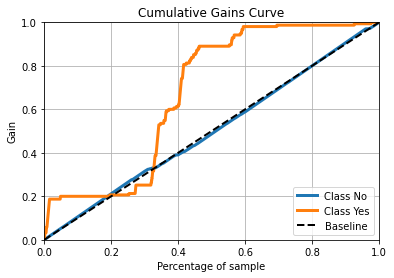

In [62]:
predicted_probabilities = clf.predict_proba(X_test, feature_names=attributes)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

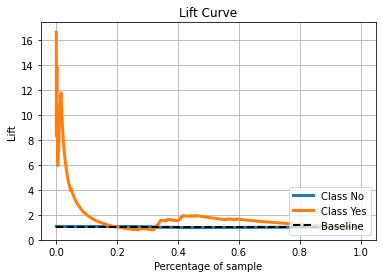

In [63]:
skplt.metrics.plot_lift_curve(y_test, predicted_probabilities)

## Roc Curve

In [64]:
lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

['No', 'Yes']

In [65]:
fpr = dict()
tpr = dict()
roc_auc = dict()
by_test_bin= lb.transform(y_test)
by_pred_bin = lb.transform(y_pred)
by_test = np.hstack((by_test_bin, 1 - by_test_bin))
by_pred = np.hstack((by_pred_bin, 1 - by_pred_bin))

In [66]:
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

array([0.58167907, 0.58167907])

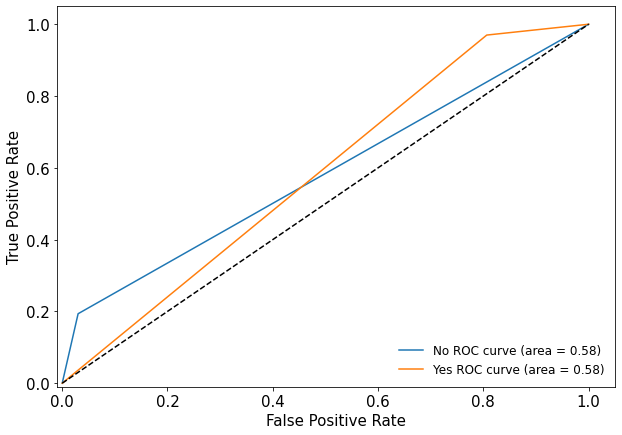

In [67]:
plt.figure(figsize=(10, 7))
for i in range(2):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.05])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.show()

### parameter tuning

In [68]:
clf = lw.RIPPER(k=3, prune_size=0.33)
clf.fit(X_train, y_train, pos_class = 'Yes',feature_names=attributes )

In [69]:
 y_pred = clf.predict(X_test, feature_names=attributes)

for i, e in enumerate(y_pred):
    if e == True : y_pred[i] = 'Yes'
    else: y_pred[i] = 'No'

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9273221919937816
F1-score [0.96127563 0.41009464]
              precision    recall  f1-score   support

          No       0.96      0.96      0.96      2418
         Yes       0.40      0.42      0.41       155

    accuracy                           0.93      2573
   macro avg       0.68      0.69      0.69      2573
weighted avg       0.93      0.93      0.93      2573



In [70]:
confusion_matrix(y_test, y_pred)

array([[2321,   97],
       [  90,   65]])

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [65, 66, 67, 68, 69, 70, 82, 83, 84, 85, 86, 87, 88, 100, 101, 102, 103, 104, 105, 106, 107, 108, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 146, 297, 298, 299, 300, 322, 323, 463, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 887, 888, 889, 890, 891, 892, 893, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

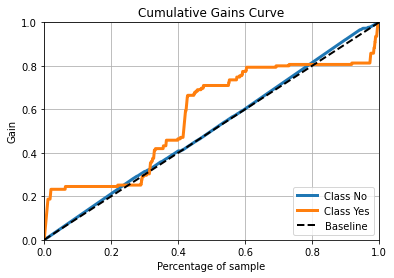

In [71]:
predicted_probabilities = clf.predict_proba(X_test, feature_names=attributes)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

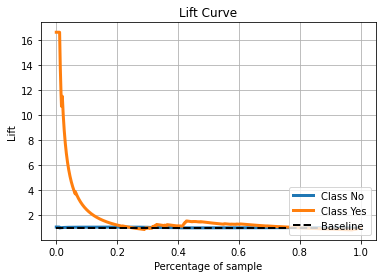

In [72]:
skplt.metrics.plot_lift_curve(y_test, predicted_probabilities)

In [73]:
fpr = dict()
tpr = dict()
roc_auc = dict()
by_test_bin= lb.transform(y_test)
by_pred_bin = lb.transform(y_pred)
by_test = np.hstack((by_test_bin, 1 - by_test_bin))
by_pred = np.hstack((by_pred_bin, 1 - by_pred_bin))

In [76]:
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(by_test[:, i], by_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

array([0.68961952, 0.68961952])

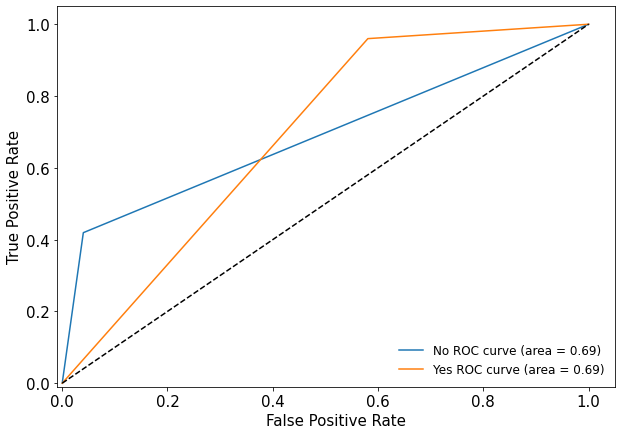

In [77]:
plt.figure(figsize=(10, 7))
for i in range(2):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.05])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc="lower right", fontsize=12, frameon=False)
plt.show()

### crossvalidation

In [78]:
df_cross = df
# modifico i valori Yes e No con 1 e 0 perché sennò il modello non riesce a fittare
df_cross.replace({'artist_wikipedia_page' : {'Yes' : 1, 'No' : 0}}, inplace = True)
attributes = [col for col in df.columns if col != 'artist_wikipedia_page']
X = df_cross[attributes].values
y = df_cross['artist_wikipedia_page']

scores = cross_val_score(clf, X, y, cv=15)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=15, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=15, scoring='recall_macro')
print('recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9004 (+/- 0.13)
F1-score: 0.6101 (+/- 0.16)
recall: 0.5856 (+/- 0.15)


### stampo le regole

In [80]:
clf.ruleset_.out_pretty()

[[Album=0 ^ Unnamed:0=0-2572 ^ artist_favorites=26-89 ^ artist_comments=0-0] V
[Album=0 ^ artist_favorites=9-15 ^ RadioProgram=1 ^ track_favorites=0-0 ^ album_tracks=10-12] V
[Album=0 ^ artist_favorites=9-15 ^ RadioProgram=1 ^ artist_associated_labels=1 ^ album_date_released=695431-732760 ^ artist_website=1] V
[Album=0 ^ Unnamed:0=0-2572 ^ album_date_released=695431-732760 ^ album_listens=4288-5756 ^ artist_comments=0-0] V
[Album=0 ^ artist_favorites=9-15 ^ Rock=1 ^ album_tracks=4-6 ^ artist_associated_labels=1] V
[Album=0 ^ artist_favorites=26-89 ^ artist_comments=4-55 ^ LivePerformance=1 ^ album_date_released=734203-734516] V
[Album=0 ^ artist_comments=1-4 ^ artist_favorites=26-89 ^ album_comments=0-0 ^ artist_associated_labels=0] V
[Album=0 ^ album_date_created=733372-733564 ^ artist_favorites=15-26 ^ Rock=1] V
[Album=0 ^ track_bit_rate=192000-256000 ^ album_favorites=1-2 ^ album_tracks=15-22] V
[artist_bio=1 ^ Album=0 ^ track_bit_rate=192000-256000 ^ artist_comments=1-4 ^ Rock=1 ^ 

In [83]:
rules = clf.ruleset_

i = 0
for e in rules:
    i = i+1
    
i

77